<a id="top"> </a>
# ToC
+ [1. Functions](#functions)
+ [2. Day1](#day1)
+ [3. KNN](#knn)
+ [4. Decision Tree](#dec_tree)
    + [4.1 Decission Tree Classification](#dec_tree_class)


In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [2]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [3]:
data_churn = pd.read_csv("../data/data_customer-churn.csv")

In [4]:
data_cust = pd.read_csv("../data/cleaned_cust_data.csv")

<a id="functions"></a>
## 1. Functions

In [5]:
def snake_case_columns(col_names:[list]=None):
    # __author__ = "Roman Kaltschew"
    """changes all columns to snake_case (from CamelCase)"""
    if not col_names or type(col_names) != list:
        print("No list of column names provided")
        return None
    new_cols = []
    for col in col_names:
        this_col = col[0].lower()
        for _ in col[1:]:
            if _.isupper():
                this_col += f"_{_.lower()}"
            else:
                this_col += _
        new_cols.append(this_col)
    return new_cols

In [6]:
def nan_values_of_all_columns(this_df, return_dict:[bool] = False):
    # __author__ = "Roman Kaltschew"
    """prints (defaults) or returns dictionary of all columns in this_df and their respective nan-values"""
    if not return_dict:
        for col in this_df.columns:
            print(col, this_df[col].isna().sum())
        return
    return {col:this_df[col].isna().sum() for col in this_df.columns}

In [7]:
def x_y_to_1_0(value:[str]=None, x="Yes", y="No", return_none:[bool]=True):
    # __author__ = "Roman Kaltschew"
    """changes the value from x-value to 1 and y-value to 0, returns None if True and value is neither x or y"""
    if value == x:
        return 1
    elif value == y:
        return 0
    else:
        if return_none:
            return None


In [8]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [9]:
def nan_values_of_all_columns(this_df, return_dict:[bool] = False):
    # __author__ = "Roman Kaltschew"
    """prints (defaults) or returns dictionary of all columns in this_df and their respective nan-values"""
    if not return_dict:
        for col in this_df.columns:
            print(col, this_df[col].isna().sum())
        return
    return {col:this_df[col].isna().sum() for col in this_df.columns}

In [10]:
def performance_model(y_train, y_test, y_pred_train, y_pred_test):

    # Model validation y_train - y_pred_train
    ME_train = np.mean(y_train-y_pred_train)
    ME_test  = np.mean(y_test-y_pred_test)

    MAE_train = mean_absolute_error(y_train,y_pred_train)
    MAE_test  = mean_absolute_error(y_test,y_pred_test)

    MSE_train = mean_squared_error(y_train,y_pred_train)
    MSE_test  = mean_squared_error(y_test,y_pred_test)

    RMSE_train = np.sqrt(MSE_train)
    RMSE_test  = np.sqrt(MSE_test)

    MAPE_train = np.mean((np.abs(y_train-y_pred_train) / y_train)* 100.)
    MAPE_test  = np.mean((np.abs(y_test-y_pred_test) / y_test)* 100.)

    R2_train = r2_score(y_train,y_pred_train)
    R2_test  = r2_score(y_test,y_pred_test)

    performance = pd.DataFrame({'Error_metric': ['Mean error','Mean absolute error','Mean squared error',
                                             'Root mean squared error','Mean absolute percentual error',
                                             'R2'],
                            'Train': [ME_train, MAE_train, MSE_train, RMSE_train, MAPE_train, R2_train],
                            'Test' : [ME_test, MAE_test , MSE_test, RMSE_test, MAPE_test, R2_test]})

    pd.options.display.float_format = '{:.2f}'.format


    df_train = pd.DataFrame({'Real_value': y_train, 'Predicted_value': y_pred_train})
    df_test  = pd.DataFrame({'Real_value': y_test,  'PRedicted_value': y_pred_test})

    return performance, df_train, df_test

In [124]:
def dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth:[int]=3, show_df:[bool]=True,
                                 return_df:[bool]=False, show_conf:[bool]=False, show_tree:[bool]=False):
    """Takes the pre-processed X_train, X_test, y_train, y_test and models decision tree, options for max_depth, displaying
       performance df, returning performance df, plotting confusion matrices and tree (default: 3, True, False, False, False)"""
    dt = DecisionTreeClassifier(max_depth=max_dpth)

    dt.fit(X_train, y_train)

    y_pred_train_dt = dt.predict(X_train)
    y_pred_test_dt = dt.predict(X_test)

    performance_df = pd.DataFrame({'error_metric': ['Accuracy','Precision','Recall'],
                                   'train': [accuracy_score(y_train, y_pred_train_dt),
                                             precision_score(y_train, y_pred_train_dt, pos_label="Yes"),
                                             recall_score(y_train, y_pred_train_dt, pos_label="Yes")],
                                   'test': [accuracy_score(y_test, y_pred_test_dt),
                                            precision_score(y_test, y_pred_test_dt, pos_label="Yes"),
                                            recall_score(y_test, y_pred_test_dt, pos_label="Yes")]})
    if show_df:
        display(performance_df)
    if show_conf:
        plot_confusion_matrix(dt,X_train,y_train, values_format = 'd')
        plt.title(f"Confusion matrix\nTrain Set with max depth of {max_dpth}")
        plot_confusion_matrix(dt,X_test,y_test, values_format = 'd')
        plt.title(f"Confusion matrix\nTest Set with max depth of {max_dpth}")
        plt.show()
    if show_tree:
        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10))
        plot_tree(model,filled = True, rounded=True, feature_names = X.columns)
        plt.title("Decision Tree")
        plt.show()
    if return_df:
        return performance_df

In [130]:
def random_forest_classifier_df(this_X_train, this_y_train, this_min_dpth:[int]=2, this_max_dpth:[int]=5, 
                                this_min_cv:[int]=5, this_max_cv:[int]=25, this_random_state=42):
    result_df = pd.DataFrame()
    for md in range(this_min_dpth, this_max_dpth+1):
        for cv_s in range(this_min_cv,this_max_cv+1,5):
            clf = RandomForestClassifier(max_depth=md, random_state=this_random_state)
            cross_val_scores = cross_val_score(clf, X_train, y_train, cv=cv_s)
            result_df = pd.concat([pd.DataFrame([[md, cv_s, np.mean(cross_val_scores)]]), result_df], axis=0)
    result_df.rename(columns={0: 'max_depth', 1: 'cv', 2:"mean_score"}, inplace=True)
    return result_df

**project specific**

In [11]:
def preprocessing(this_df):
    # __author__ = "Roman Kaltschew"    
    """Project Specific, following instructions from LabWorks Week7 day2"""
    # snake case for all columns
    this_df.columns = snake_case_columns(list(this_df.columns))
    this_df.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)
    # drop the " " from total_charges
    this_df = this_df[this_df.total_charges != " "]
    # change total_charges to float64
    this_df["total_charges"] = this_df["total_charges"].astype("float64")
    # return only relevant columns
    return this_df[["tenure", "senior_citizen", "monthly_charges", "total_charges", "churn"]]

In [13]:
"""
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
churnData['Churn']= label_encoder.fit_transform(churnData['Churn'] ) 
churnData.head(2)
"""

"\nfrom sklearn import preprocessing \nlabel_encoder = preprocessing.LabelEncoder()\nchurnData['Churn']= label_encoder.fit_transform(churnData['Churn'] ) \nchurnData.head(2)\n"

[top](#top)

## Placehodler Day 1

<a id= "knn"></a>
## 3. KNN

### Classification Problem

In [14]:
data = preprocessing(data_churn)
data

,tenure,senior_citizen,monthly_charges,total_charges,churn
0,1,0,29.85,29.85,No
1,34,0,56.95,1889.50,No
2,2,0,53.85,108.15,Yes
3,45,0,42.30,1840.75,No
4,2,0,70.70,151.65,Yes
...,...,...,...,...,...
7038,24,0,84.80,1990.50,No
7039,72,0,103.20,7362.90,No
7040,11,0,29.60,346.45,No
7041,4,1,74.40,306.60,Yes


In [15]:
X = data.drop(["churn"], axis=1)
y = (data["churn"])

,Error_metric,Train,Test
0,Accuracy,0.793778,0.780384
1,Precision,0.658768,0.624521
2,Recall,0.464883,0.435829


Confusion matrix for the train set
[[3770  360]
 [ 800  695]]


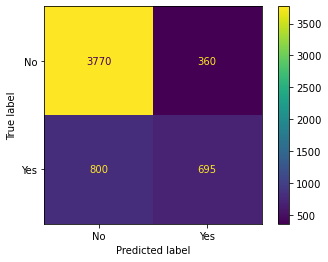



Confusion matrix for the test set
[[935  98]
 [211 163]]


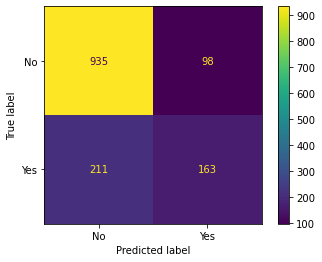

In [16]:
log_model = LogisticRegression() 

## Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

trans = StandardScaler()

trans.fit(X_train)

X_train_mod = trans.transform(X_train)
X_test_mod  = trans.transform(X_test)

log_model.fit(X_train_mod, y_train)

y_pred_train_log = log_model.predict(X_train_mod)
y_pred_test_log = log_model.predict(X_test_mod)

performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_log),
                                         precision_score(y_train, y_pred_train_log, pos_label="Yes"),
                                         recall_score(y_train, y_pred_train_log, pos_label="Yes")],
                               'Test': [accuracy_score(y_test, y_pred_test_log),
                                        precision_score(y_test, y_pred_test_log, pos_label="Yes"),
                                        recall_score(y_test, y_pred_test_log, pos_label="Yes")]})

display(performance_log)

print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train_log))
plot_confusion_matrix(log_model,X_train_mod,y_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_log))
plot_confusion_matrix(log_model,X_test_mod,y_test, values_format = 'd')
plt.show()

<a id = "dec_tree"></a>
## 4. Decision Tree

<a id = "dec_tree_class"></a>
### 4.1 Classification

#### 4.1.1 Using only the four numerical columns from LabWorks description
(week 7, day 2)

In [17]:
data_ = preprocessing(data_churn)

In [18]:
X = data_.drop(columns=["churn"], axis = 1)
y = data_["churn"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

**Compare different levels of depth**

In [20]:
compare_performance_df = pd.DataFrame()

for depth in range(2,8):
    dt = DecisionTreeClassifier(max_depth=depth)

    dt.fit(X_train, y_train)

    y_pred_train_dt = dt.predict(X_train)
    y_pred_test_dt = dt.predict(X_test)

    performance_df = pd.DataFrame({"depth" : depth,
                                   'error_metric': ['Accuracy','Precision','Recall'],
                                   'train': [accuracy_score(y_train, y_pred_train_dt),
                                             precision_score(y_train, y_pred_train_dt, pos_label="Yes"),
                                             recall_score(y_train, y_pred_train_dt, pos_label="Yes")],
                                   'test': [accuracy_score(y_test, y_pred_test_dt),
                                            precision_score(y_test, y_pred_test_dt, pos_label="Yes"),
                                            recall_score(y_test, y_pred_test_dt, pos_label="Yes")]})
    
    compare_performance_df = pd.concat([compare_performance_df,performance_df], axis=0)

In [21]:
compare_performance_df
# compare_performance_df.sort_values(["error_metric", "depth"], ascending = (True, True)) # sorted by error_metric and depth

,depth,error_metric,train,test
0,2,Accuracy,0.788501,0.771564
1,2,Precision,0.659880,0.605898
2,2,Recall,0.421254,0.402852
0,3,Accuracy,0.788501,0.771564
1,3,Precision,0.659880,0.605898
2,3,Recall,0.421254,0.402852
0,4,Accuracy,0.798659,0.778199
1,4,Precision,0.672096,0.615385
2,4,Recall,0.473242,0.442068
0,5,Accuracy,0.800081,0.774408


In [22]:
# fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (10,8))
# sns.lineplot(data=compare_performance_df, x=compare_performance_df.depth)


#### 4.1.2 Use depth of 4, include confusion matrices and tree plot
changing from 3 to 4 results in a jump in **recall score** of test set by **+4 %**

In [23]:
X = data_.drop(columns=["churn"], axis = 1)
y = data_["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

,error_metric,train,test
0,Accuracy,0.798659,0.778199
1,Precision,0.672096,0.615385
2,Recall,0.473242,0.442068


Confusion matrix for the train set


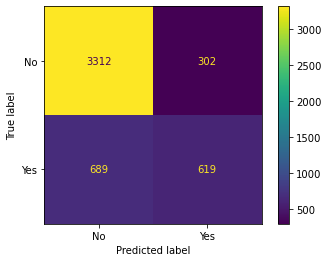

Confusion matrix for the test set


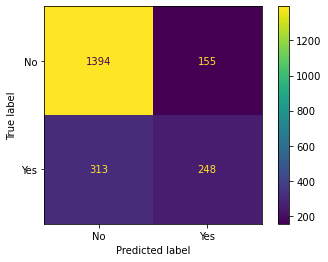

Tree plot


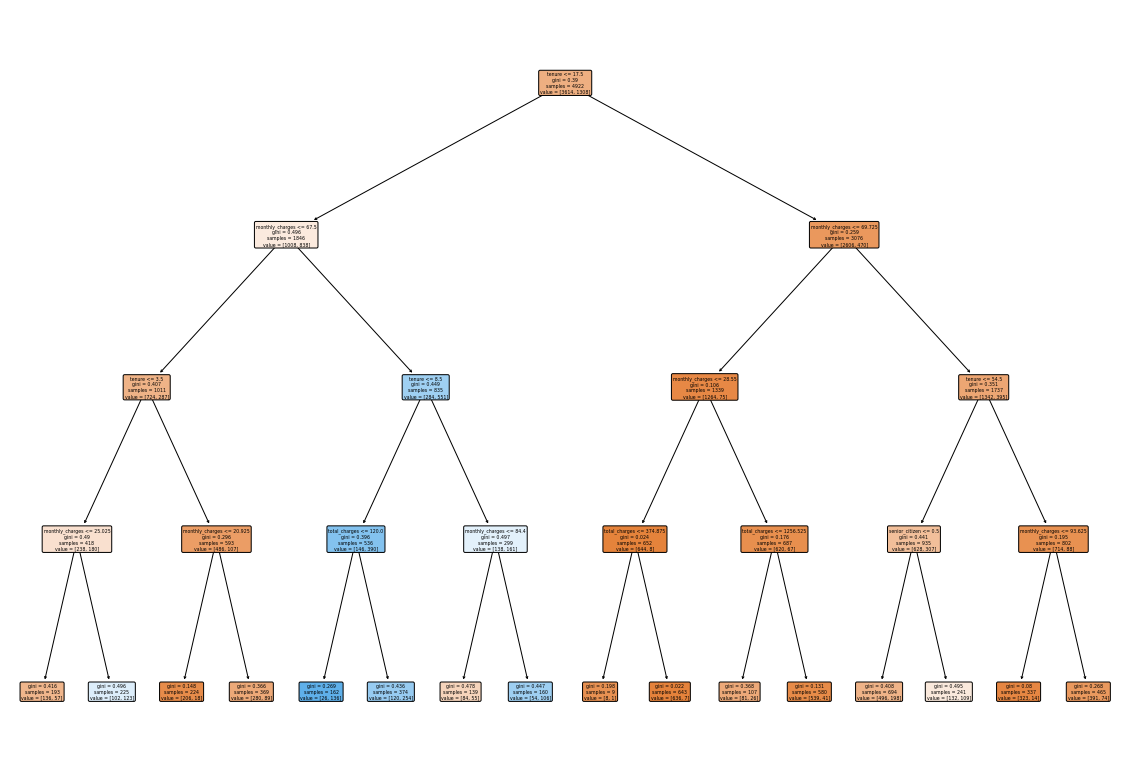

In [24]:
# dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt = DecisionTreeClassifier(max_depth=4, random_state=42)

dt.fit(X_train, y_train)

y_pred_train_dt = dt.predict(X_train)
y_pred_test_dt = dt.predict(X_test)

performance_df = pd.DataFrame({'error_metric': ['Accuracy','Precision','Recall'],
                               'train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt, pos_label="Yes"),
                                         recall_score(y_train, y_pred_train_dt, pos_label="Yes")],
                               'test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt, pos_label="Yes"),
                                        recall_score(y_test, y_pred_test_dt, pos_label="Yes")]})

display(performance_df)

print("Confusion matrix for the train set")

plot_confusion_matrix(dt,X_train,y_train, values_format = 'd')
plt.show()

print("Confusion matrix for the test set")

plot_confusion_matrix(dt,X_test,y_test, values_format = 'd')
plt.show()

print("Tree plot")
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,14)) # ,dpi=200)

plot_tree(dt,filled = True, rounded=True, feature_names = X.columns)
plt.show() 

#### 4.1.3 include categorical columns from original dataset

In [25]:
data_ = data_churn.copy()

In [26]:
# remove " " values from total_charge and set type as float
data_ = data_[data_.total_charges != " "]
data_["total_charges"] = data_["total_charges"].astype("float64")


In [27]:
X = data_.drop(columns=["churn"], axis = 1)
y = data_["churn"]


In [28]:
categoricals_features= X.select_dtypes("object")
cat_cols=pd.get_dummies(categoricals_features, drop_first=True)
# cat_cols

In [29]:
X = X._get_numeric_data()
X = pd.concat([X,cat_cols],axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

,error_metric,train,test
0,Accuracy,0.799269,0.779621
1,Precision,0.670576,0.617073
2,Recall,0.480887,0.450980


Confusion matrix for the train set


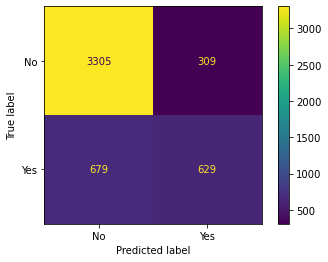

Confusion matrix for the test set


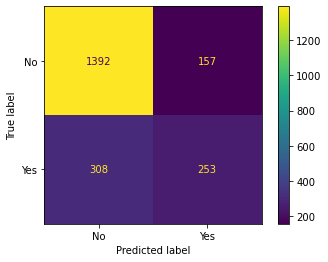

Tree plot


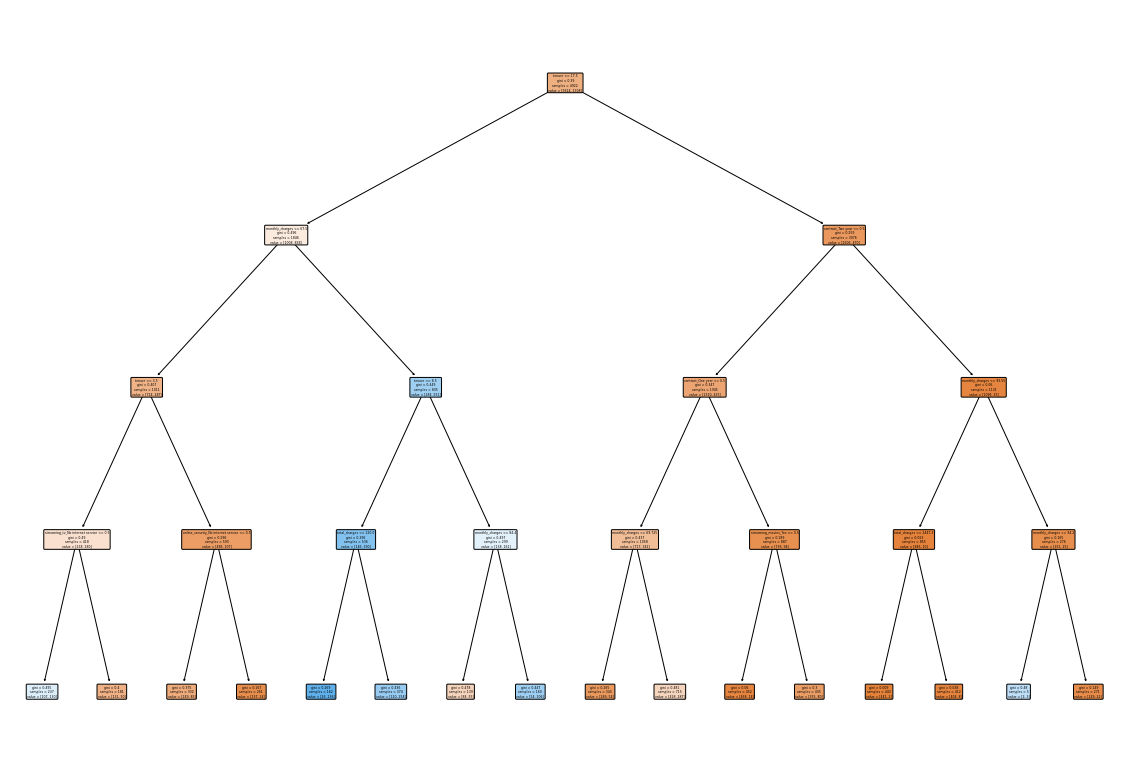

In [31]:
dt = DecisionTreeClassifier(max_depth=4)

dt.fit(X_train, y_train)

y_pred_train_dt = dt.predict(X_train)
y_pred_test_dt = dt.predict(X_test)

performance_df = pd.DataFrame({'error_metric': ['Accuracy','Precision','Recall'],
                               'train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt, pos_label="Yes"),
                                         recall_score(y_train, y_pred_train_dt, pos_label="Yes")],
                               'test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt, pos_label="Yes"),
                                        recall_score(y_test, y_pred_test_dt, pos_label="Yes")]})

display(performance_df)

print("Confusion matrix for the train set")

plot_confusion_matrix(dt,X_train,y_train, values_format = 'd')
plt.show()

print("Confusion matrix for the test set")

plot_confusion_matrix(dt,X_test,y_test, values_format = 'd')
plt.show()

print("Tree plot")
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,14))

plot_tree(dt,filled = True, rounded=True, feature_names = X.columns)
plt.show() 

<a id = "dec_tree_linreg"></a>
### 4.2 Decision Tree LinearRegression

In [32]:
data_ = data_cust.copy()

In [33]:
data_ = data_._get_numeric_data()
# data_

In [34]:
X = data_.drop(columns=["total_claim_amount"], axis = 1)
y = data_["total_claim_amount"]

In [35]:
#X = X._get_numeric_data()
# X

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [37]:
model = DecisionTreeRegressor(max_depth=3)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

performance, _ ,_ = performance_model(y_train, y_test, y_pred_train, y_pred_test)
performance

,Error_metric,Train,Test
0,Mean error,0.00,2.77
1,Mean absolute error,151.63,152.43
2,Mean squared error,42003.78,40254.75
3,Root mean squared error,204.95,200.64
4,Mean absolute percentual error,inf,inf
5,R2,0.51,0.51


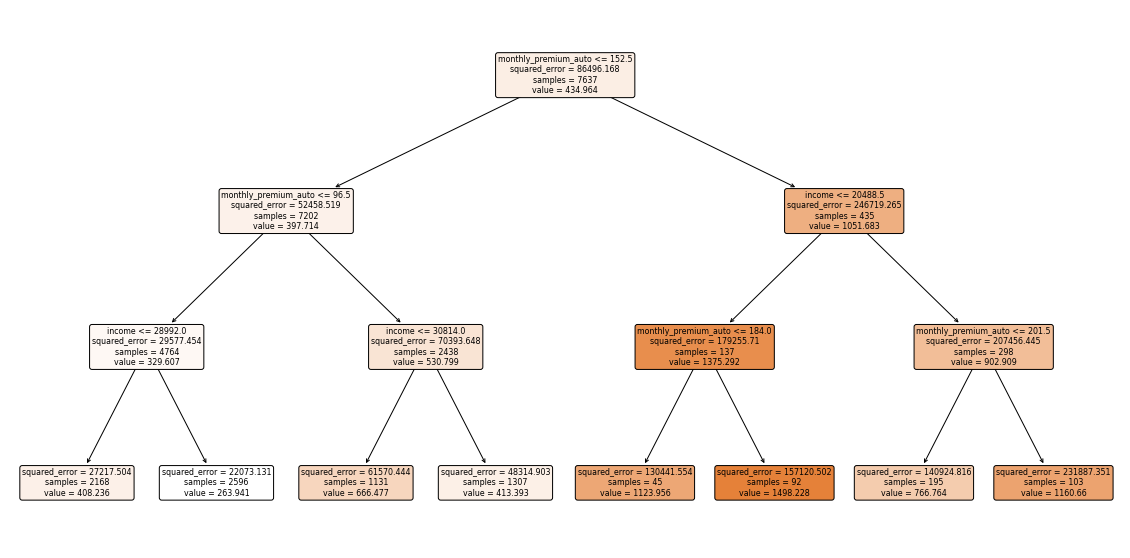

In [38]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10))

plot_tree(model,filled = True, rounded=True, feature_names = X.columns)
plt.show()  

## Cross Validation

### 5.1 Classification 

In [39]:
data_ = preprocessing(data_churn)

X = data_.drop(columns=["churn"], axis = 1)
y = data_["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [40]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7100213219616205

In [41]:
#model1 = DecisionTreeRegressor()
model1 = DecisionTreeClassifier()
# model2 = LinearRegression()
model2 = LogisticRegression()
# model3 = KNeighborsRegressor()
model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Regression Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_names[i]] = round(mean_score, 4)
    i = i+1

pd.DataFrame.from_dict(scores.items()).rename({0:"Model",1:"Accuracy"}, axis=1)

,Model,Accuracy
0,Regression Tree,0.72
1,Logistic Regression,0.79
2,KNN,0.76


### 5.2 LinearRegeression

In [86]:
data_ = data_cust.copy()

data_ = data_._get_numeric_data()


X = data_.drop(columns=["total_claim_amount"], axis = 1)
y = data_["total_claim_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [87]:
data_

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809,48029,61,7,52,0.00,9,292,2
1,2228,0,64,3,26,0.00,1,744,1
2,14947,22139,100,34,31,0.00,2,480,2
3,22332,49078,97,10,3,0.00,2,484,1
4,9025,23675,117,15,31,0.00,7,707,1
...,...,...,...,...,...,...,...,...,...
10905,15563,0,253,15,40,0.00,7,1214,1
10906,5259,61146,65,7,68,0.00,6,273,1
10907,23893,39837,201,11,63,0.00,2,381,2
10908,11971,64195,158,0,27,4.00,6,618,2


In [43]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_train)
# y_pred_test  = model.predict(X_test)

r2_=r2_score(y_train,y_pred)

r2_

0.5208845836696386

In [44]:
model1 = DecisionTreeRegressor()

model2 = LinearRegression()

model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Regression Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_names[i]] = round(mean_score, 4)
    i = i+1

pd.DataFrame.from_dict(scores.items()).rename({0:"Model",1:"R²"}, axis=1)

,Model,R²
0,Regression Tree,0.33
1,Logistic Regression,0.52
2,KNN,0.18


## Handling Imbalanced Data

In [45]:
data_ = preprocessing(data_churn)

The *churn* column is a bit imbalanced:

In [46]:
print(f"Yes: {round((len(data_[data_.churn == 'Yes']))*100/len(data_), 2)} % ({(len(data_[data_.churn == 'Yes']))})")
print(f"No : {round((len(data_[data_.churn == 'No']))*100/len(data_), 2)} % ({len(data_[data_.churn == 'No'])})")

Yes: 26.58 % (1869)
No : 73.42 % (5163)


<a id="down_sampling"></a>
### 6.1 Downsampling

create a new dataframe with the length of the minority class consisting out of randomly chosen datapoints from the majority class.

In [78]:
cat_yes = data_[data_.churn == "Yes"]
cat_no  = data_[data_.churn == "No"]

In [79]:
cat_no_down = cat_no.sample(len(cat_yes))
len(cat_no_down) == len(cat_yes)

True

In [80]:
data_down = pd.concat([cat_yes, cat_no_down], axis=0)
data_down = data_down.sample(frac=1)

In [81]:
print(f"data_down is exactly twice the size of minority class: {len(data_down) == 2*len(cat_yes)}.")

data_down is exactly twice the size of minority class: True.


#### 6.1.1 performance of downsampled data  (only numerical data)

In [82]:
X = preprocessing(data_down).drop(['churn'], axis=1)
y = preprocessing(data_down).churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = DecisionTreeClassifier()


#model1 = DecisionTreeRegressor()
model1 = DecisionTreeClassifier()
# model2 = LinearRegression()
model2 = LogisticRegression()
# model3 = KNeighborsRegressor()
model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Regression Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_names[i]] = round(mean_score, 4)
    i = i+1

pd.DataFrame.from_dict(scores.items()).rename({0:"Model",1:"Accuracy"}, axis=1)

,Model,Accuracy
0,Regression Tree,0.66
1,Logistic Regression,0.73
2,KNN,0.70


#### 6.1.2 Using down sampled Dataframe on different sizes and with different depths (only numerical data)

In [51]:
X_ds = data_down._get_numeric_data()
y_ds = data_down.churn

In [52]:
min_test_size = 10
max_test_size = 30
max_depth = 6

combined_df = pd.DataFrame()
for size in range(min_test_size,max_test_size+1,5):
    X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=size/100)
    for _ in range(3,max_depth):
        # print(f"Testsize {size/100}, Depth {_}")
        # dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth=_)
        this = dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth=_, show_df=False, return_df=True)
        this["testsize"] = size
        this["depth"] = _
        combined_df = pd.concat([combined_df,this], axis=0)
        

In [53]:
combined_df = combined_df[["testsize", "depth", "error_metric", "train", "test"]]
# combined_df.sort_values(["testsize", "error_metric", "depth"])

**Highest scores for set test_size and max depth**

In [54]:
si = int(combined_df[combined_df.test == max(combined_df.test)]["testsize"].iloc[0])
de = int(combined_df[combined_df.test == max(combined_df.test)]["depth"].iloc[0])
combined_df[(combined_df.testsize == si) & (combined_df.depth == de)]

,testsize,depth,error_metric,train,test
0,15,3,Accuracy,0.74,0.73
1,15,3,Precision,0.69,0.66
2,15,3,Recall,0.86,0.85


<a id="up_sampling1"></a>
### 6.2 Upsampling Method 1
create a new dataframe with the length of the majority class out of randomly chosen datapoints from the minority class (used for several<br> times to "fill" needed spaces). 

In [72]:
cat_yes = preprocessing(data_)[data_.churn == "Yes"]
cat_no  = preprocessing(data_)[data_.churn == "No"]

In [73]:
cat_yes_up = cat_yes.sample(len(cat_no), replace=True)
print(len(cat_yes_up)==len(cat_no))

True


In [74]:
data_up1 = pd.concat([cat_yes_up, cat_no], axis=0)
data_up1 = data_up1.sample(frac=1)

In [75]:
print(f"data_up1 is exactly twice the size of majority class: {len(data_up1) == 2*len(cat_no)}.")

data_up1 is exactly twice the size of majority class: True.


#### 6.2.1 performance evaluation traditional upsampling

In [77]:
X = preprocessing(data_up1).drop(['churn'], axis=1)
y = preprocessing(data_up1).churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = DecisionTreeClassifier()


#model1 = DecisionTreeRegressor()
model1 = DecisionTreeClassifier()
# model2 = LinearRegression()
model2 = LogisticRegression()
# model3 = KNeighborsRegressor()
model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Regression Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_names[i]] = round(mean_score, 4)
    i = i+1

pd.DataFrame.from_dict(scores.items()).rename({0:"Model",1:"Accuracy"}, axis=1)

,Model,Accuracy
0,Regression Tree,0.86
1,Logistic Regression,0.74
2,KNN,0.76


#### 6.2.2 Using up sampled Dataframe on different sizes and with different depths

In [59]:
X_ups = data_up1.drop(['churn'], axis=1)
y_ups = preprocessing(data_up1).churn

In [60]:
min_test_size = 10
max_test_size = 30
max_depth = 6

combined_df = pd.DataFrame()
for size in range(min_test_size,max_test_size+1,5):
    X_train, X_test, y_train, y_test = train_test_split(X_ups, y_ups, test_size=size/100)
    for _ in range(3,max_depth):
        # print(f"Testsize {size/100}, Depth {_}")
        # dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth=_)
        this = dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth=_, show_df=False, return_df=True)
        this["testsize"] = size
        this["depth"] = _
        combined_df = pd.concat([combined_df,this], axis=0)

In [61]:
combined_df = combined_df[["testsize", "depth", "error_metric", "train", "test"]]
# combined_df.sort_values(["testsize", "error_metric", "depth"])

**Highest scores for set test_size and max depth**

In [62]:
si = int(combined_df[combined_df.test == max(combined_df.test)]["testsize"].iloc[0])
de = int(combined_df[combined_df.test == max(combined_df.test)]["depth"].iloc[0])
combined_df[(combined_df.testsize == si) & (combined_df.depth == de)]

,testsize,depth,error_metric,train,test
0,25,3,Accuracy,0.73,0.73
1,25,3,Precision,0.68,0.70
2,25,3,Recall,0.85,0.85


In [63]:
combined_df[combined_df.test == max(combined_df.test)]["testsize"]

2    25
Name: testsize, dtype: int64

<a id="smote"></a>
### 6.3 Upsampling Method 2 - SMOTE

create a new dataframe with the length of the majority class by randomly choosing a point from the minority class, computing its<br>
k-nearest neighbors (for some pre-specified k) and add k new points somewhere between the chosen point and each of its <br>neighbors.

In [64]:
smote = SMOTE()

In [65]:
X = preprocessing(data_).drop(['churn'], axis=1)
y = preprocessing(data_).churn

In [66]:
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5163
Yes    5163
Name: churn, dtype: int64

#### 6.3.1 Performance of upsampled data

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7405614714424008

In [68]:
#model1 = DecisionTreeRegressor()
model1 = DecisionTreeClassifier()
# model2 = LinearRegression()
model2 = LogisticRegression()
# model3 = KNeighborsRegressor()
model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Regression Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_names[i]] = round(mean_score, 4)
    i = i+1

pd.DataFrame.from_dict(scores.items()).rename({0:"Model",1:"Accuracy"}, axis=1)

,Model,Accuracy
0,Regression Tree,0.75
1,Logistic Regression,0.74
2,KNN,0.77


#### 6.3.2 Using SMOTE upsampled Dataframe on different sizes and with different depths (decision tree)

In [69]:
min_test_size = 10
max_test_size = 30
max_depth = 6

combined_df = pd.DataFrame()
for size in range(min_test_size,max_test_size+1,5):
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=size/100)
    for _ in range(3,max_depth+1):
#         print(f"Testsize {size/100}, Depth {_}")
#         dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth=_)
        this = dec_tree_class_conf_matrices(X_train, X_test, y_train, y_test, max_dpth=_, show_df=False, return_df=True)
        this["testsize"] = size
        this["depth"] = _
        combined_df = pd.concat([combined_df,this], axis=0)

In [70]:
combined_df = combined_df[["testsize", "depth", "error_metric", "train", "test"]]
# combined_df.sort_values(["testsize", "error_metric", "depth"])

**Highest scores for set test_size and max depth**

In [71]:
si = int(combined_df[combined_df.test == max(combined_df.test)]["testsize"])
de = int(combined_df[combined_df.test == max(combined_df.test)]["depth"])
combined_df[(combined_df.testsize == si) & (combined_df.depth == de)]

,testsize,depth,error_metric,train,test
0,20,3,Accuracy,0.74,0.73
1,20,3,Precision,0.68,0.67
2,20,3,Recall,0.89,0.88


In [83]:
# TODO: add some categoricals columns to check for impact (length of contract!!!)

In [ ]:
## 

## 7. Random Forest

### 7.1 Using the churn data set, only numerical features

In [140]:
data_ = preprocessing(data_churn)

X = data_.drop(columns=["churn"], axis = 1)
y = data_["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

**Basic Random Forest Classifier**

In [113]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.7746979388770433


**Different Values for max_depth and cv**

In [127]:
random_forest_classifier_df(X_train, y_train, this_min_dpth=4, this_max_dpth=5, this_max_cv=25, this_random_state=42)

,max_depth,cv,mean_score
0,4,25,0.75
0,4,20,0.75
0,4,15,0.75
0,4,10,0.75
0,4,5,0.75
0,3,25,0.74
0,3,20,0.74
0,3,15,0.74
0,3,10,0.74
0,3,5,0.74


**Different Values for max_depth and cv, down sampled data**

In [143]:
cat_yes = data_[data_.churn == "Yes"]
cat_no  = data_[data_.churn == "No"]

cat_no_down = cat_no.sample(len(cat_yes))


data_down = pd.concat([cat_yes, cat_no_down], axis=0)
data_down = data_down.sample(frac=1)

In [144]:
X = data_.drop(columns=["churn"], axis = 1)
y = data_["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [117]:
random_forest_classifier_df(X_train, y_train, this_max_dpth=5, this_max_cv=25, this_random_state=42)

,0,1,2
0,4,25,0.79
0,4,20,0.79
0,4,15,0.79
0,4,10,0.79
0,4,5,0.79
0,3,25,0.79
0,3,20,0.79
0,3,15,0.79
0,3,10,0.79
0,3,5,0.79


**Different Values for max_depth and cv, up sampled data using SMOTE**

In [135]:
smote = SMOTE()

X = preprocessing(data_).drop(['churn'], axis=1)
y = preprocessing(data_).churn

X_sm, y_sm = smote.fit_resample(X, y)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20)

In [131]:
random_forest_classifier_df(X_train, y_train, this_min_dpth=4, this_max_dpth=5, this_min_cv=20, this_max_cv=25, this_random_state=42)

,max_depth,cv,mean_score
0,5,25,0.75
0,5,20,0.75
0,4,25,0.75
0,4,20,0.75


## 8. Hyperparameter Tuning

In [132]:
param_grid = {
    'n_estimators': [50, 100,500],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
#    'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=100)

In [137]:
smote = SMOTE()

X = preprocessing(data_).drop(['churn'], axis=1)
y = preprocessing(data_).churn

X_sm, y_sm = smote.fit_resample(X, y)
# y_sm.value_counts()

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20)

In [145]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

grid_search.fit(X_train,y_train)

grid_search.best_params_ #To check the best set of parameters returned

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

using these param's in the model

In [146]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=2, min_samples_split=2, n_estimators=500)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.7738715447873934
